# 邻域分析 —— 缓冲区，最近邻

深入研究一些最常见的空间运算。在这部分之后，你将能够回答一些简单的问题，比如“最近的温蒂汉堡在哪里?”、“在距离高速公路 50 码范围内是否有住宅？”。

## 缓冲区分析

首先，将导入必要的模块。

In [1]:
# Import modules
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
from io import StringIO 

data = """
ID,X,Y
1,  -87.789,  41.976
1,  -87.482,  41.677
2,  -87.599,  41.908
2,  -87.598,  41.708
2,  -87.643,  41.675
"""
# use StringIO to read in text chunk
df = pd.read_table(StringIO(data), sep=',')

#zip the coordinates into a point object and convert to a GeoData Frame
points = [Point(xy) for xy in zip(df.X, df.Y)]
points = gpd.GeoDataFrame(df, geometry=points, crs = 'EPSG:4326')
# create line for each ID 
lines = points.groupby(['ID'])['geometry'].apply(lambda x:  LineString(x.tolist()))
lines = gpd.GeoDataFrame(lines, geometry='geometry', crs="EPSG:4326") 
lines.reset_index(inplace=True)

看看数据：

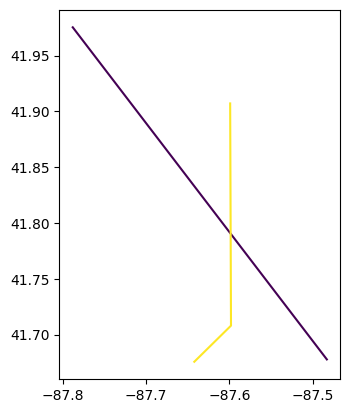

In [2]:
# plot county outline and add wells to axis (ax)
lines.plot(column='ID');

```{important}
永远不要用未被投影的数据（例如 lat lon）进行距离分析。距离最好不要用度数来衡量！而是，使用 `.to_crs()` 将其转换为投影的坐标系统，以英尺或米等为线性单位。
```

虽然没有明确说明，但距离参数是用投影的线性单位度量的。因此，在开始之前，需要确保使用 `to_crs()` 将其转换为投影坐标系。

In [3]:
# plot county outline and add wells to axis (ax)
lines = lines.to_crs(3857)
# check the linear unit name in `unit_name`.
print(lines.crs.axis_info)

[Axis(name=Easting, abbrev=X, direction=east, unit_auth_code=EPSG, unit_code=9001, unit_name=metre), Axis(name=Northing, abbrev=Y, direction=north, unit_auth_code=EPSG, unit_code=9001, unit_name=metre)]


可以开始处理缓冲区函数。你可以阅读文档的缓冲功能，不幸的是被分成两个文档[geopandas](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.buffer.html)和[shashaely](https://shapely.readthedocs.io/en/latest/manual.html#object.buffer)。

0    POLYGON ((-9737657.488 5113325.388, -9737601.7...
1    POLYGON ((-9750364.761 5117342.850, -9750369.3...
dtype: geometry


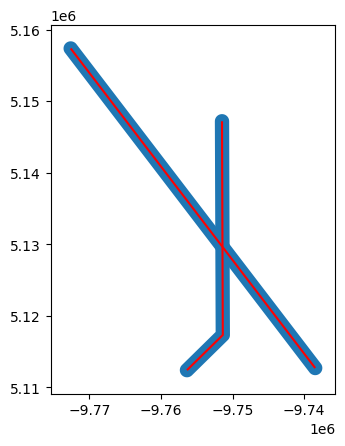

In [4]:
buf = lines.buffer(distance = 1000)
bp = buf.plot()
lines.plot(ax=bp, color='red')
print(buf)

注意，现在必须使用 polygon GEOMETRIES。它不再具有与之关联的线属性。如果想要添加回属性数据，需要用新的缓冲区几何值替换原来的几何列。

In [5]:
line_buffer = lines.copy()
line_buffer['geometry'] = buf
print(line_buffer)

   ID                                           geometry
0   1  POLYGON ((-9737657.488 5113325.388, -9737601.7...
1   2  POLYGON ((-9750364.761 5117342.850, -9750369.3...


还有许多其他参数可以使用，即 `cap_style` 和 `single_sided`。

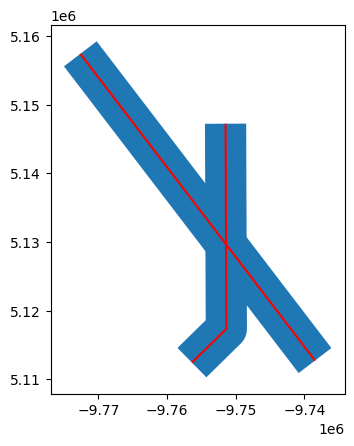

In [6]:
buf = lines.buffer(distance = 3000, cap_style = 2)
bp = buf.plot()
lines.plot(ax=bp, color='red');

属性|值
:-|:-
round|1
flat|2
square|3

还可以创建左侧或右侧缓冲区。左边使用负距离，右边使用正距离。

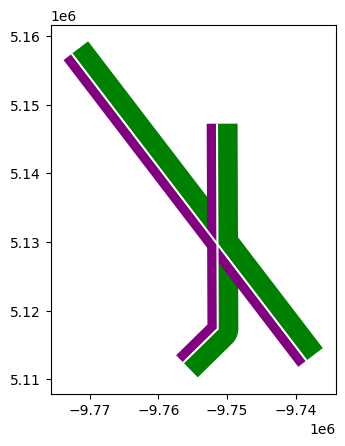

In [7]:
buf_right = lines.buffer(distance = 3000, single_sided = True)
bp = buf_right.plot(color='green')

buf_left = lines.buffer(distance = -1500, single_sided = True)
buf_left.plot(ax=bp, color='purple')
lines.plot(ax=bp, color='white');

## 最近邻分析

常用的 GIS 任务是能够找到最近的邻居。例如，您可能用 Point 对象表示您的家位置，然后用另一组位置表示公共交通站点。然后，比较典型的问题是“哪一站离我家最近?”这是典型的最近邻分析，其目标是找到与另一个几何最接近的几何。

在 Python 中，这种分析可以通过名为 `nearest_points()` 的形状良好的函数来完成，该函数返回输入几何图形中最近点的元组。

### Shapely 最近的点

从测试如何使用 Shapely 的 {func}`nearest_points` 函数找到最近的点开始。

创建原点（origin Point）和几个目的地点，并找出最近的目的地。

In [8]:
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points

orig = Point(1, 1.67)
dest1, dest2, dest3 = Point(0, 1.45), Point(2, 2), Point(0, 2.5)

为了能够从原点找到最近的目标点，需要从目标点创建 MultiPoint 对象。

In [9]:
destinations = MultiPoint([dest1, dest2, dest3])
print(destinations)

MULTIPOINT (0 1.45, 2 2, 0 2.5)


好了，现在可以看到所有的目标点都表示为单一的多点对象。可以通过使用 `nearest_points()` 函数找到最近的目标点。

In [10]:
nearest_geoms = nearest_points(orig, destinations)
original_point, nearest_destination = nearest_geoms
print(nearest_geoms)
print('Coordinates of original point:',original_point)
print('Coordinates of closest destination point:',nearest_destination)

(<shapely.geometry.point.Point object at 0x7fa20a2a6fe0>, <shapely.geometry.point.Point object at 0x7fa20a2a54b0>)
Coordinates of original point: POINT (1 1.67)
Coordinates of closest destination point: POINT (0 1.45)


如您所见，`nearest_points` 函数返回几何图形元组，其中第一项是原点的几何图形，第二项（在索引 1 处）是距离目标点最近的实际几何图形。因此，最近的目的地点似乎位于坐标 $(0,1.45)$。

这就是从一组点中找到最近点的基本逻辑。

### geopanda 最近的点

当然，前面的例子还没有真正有用。因此，接下来将展示如何使用 GeoDataFrames 从一组原点到一组目的地点中找到最近的点。在本例中，将重新创建前面的示例，但使用 geopanda，但该数据可以来自任何 shapefile。

- 首先，需要创建函数，该函数利用前面的函数，但被定制为可以使用两个 `GeoDataFrames`。

In [11]:
from shapely.ops import nearest_points

def _nearest(row, df1, df2, geom1='geometry', geom2='geometry', df2_column=None):
    """Find the nearest point and return the corresponding value from specified column."""

    # create object usable by Shapely
    geom_union = df2.unary_union

    # Find the geometry that is closest
    nearest = df2[geom2] == nearest_points(row[geom1], geom_union)[1]
    # Get the corresponding value from df2 (matching is based on the geometry)
    if df2_column is None:
        value = df2[nearest].index[0]
    else:
        value = df2[nearest][df2_column].values[0]
    return value

def nearest(df1, df2, geom1_col='geometry', geom2_col='geometry', df2_column=None):
    """Find the nearest point and return the corresponding value from specified column.
    :param df1: Origin points
    :type df1: geopandas.GeoDataFrame
    :param df2: Destination points
    :type df2: geopandas.GeoDataFrame
    :param geom1_col: name of column holding coordinate geometry, defaults to 'geometry'
    :type geom1_col: str, optional
    :param geom2_col: name of column holding coordinate geometry, defaults to 'geometry'
    :type geom2_col: str, optional
    :param df2_column: column name to return from df2, defaults to None
    :type df2_column: str, optional
    :return: df1 with nearest neighbor index or df2_column appended
    :rtype: geopandas.GeoDataFrame
    """
    df1['nearest_id'] = df1.apply(_nearest,  df1=df1, df2=df2, 
                                  geom1=geom1_col, geom2=geom2_col, 
                                  df2_column=df2_column, axis=1)
    return df1 

In [12]:
# generate origin and destination points as geodataframe
orig = {'name': ['Origin_1','Origin_2'], 
     'geometry': [Point(-77.3,38.94),Point(-77.41,39.93)]}
orig = gpd.GeoDataFrame(orig, crs="EPSG:4326")
print(orig)

dest = {'name': ['Baltimore','Washington', 'Fredrick'], 
     'geometry': [ Point(-76.61,39.29,), Point(-77.04,38.91), Point(-77.40,39.41)]}
dest = gpd.GeoDataFrame(dest, crs="EPSG:4326")
print(dest)

       name                    geometry
0  Origin_1  POINT (-77.30000 38.94000)
1  Origin_2  POINT (-77.41000 39.93000)
         name                    geometry
0   Baltimore  POINT (-76.61000 39.29000)
1  Washington  POINT (-77.04000 38.91000)
2    Fredrick  POINT (-77.40000 39.41000)


找到 `df2` 到 `df1` 质心的最近点（从 `id` 列取值）

In [13]:
nearest = nearest(df1=orig, df2=dest, df2_column='name')
nearest.head()

,name,geometry,nearest_id
0,Origin_1,POINT (-77.30000 38.94000),Washington
1,Origin_2,POINT (-77.41000 39.93000),Fredrick


```{note}
如果想用多边形做最近邻分析，可以简单地使用质心（centroid）。如果有一个叫 `poly` 的 geopandas 多边形，运行 `poly[‘centroid’] = poly.centroid` 以在属性表中存储质心值。
```